# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
import tensorflow as tf
tf.reset_default_graph()

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


In [3]:
import numpy as np

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

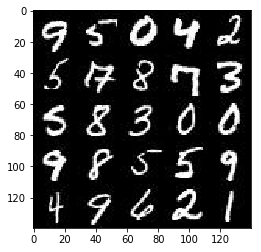

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

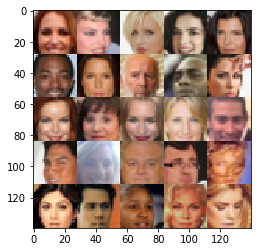

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='input_real')
    input_z = tf.placeholder(tf.float32,(None,z_dim),name='input_z')
    learning_rate = tf.placeholder(tf.float32,None,name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [38]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha3 = 0.3
    alpha2 = 0.2
    stddev = 0.02
    
    with tf.variable_scope('discriminator',reuse=reuse):
        
        # img size 28*28*3
        layer1=tf.layers.conv2d(images,64,5,strides=1,padding='SAME',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer1=tf.layers.dropout(layer1, rate=0.5)
        relu1=tf.maximum(alpha3 * layer1, layer1)
        
        # img size 28*28*64
        layer2=tf.layers.conv2d(images,128,5,strides=2,padding='SAME',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer2 = tf.layers.batch_normalization(layer2,training=True)
        layer2=tf.layers.dropout(layer2, rate=0.5)
        relu2=tf.maximum(alpha2 * layer2, layer2)
        
        # img size 14*14*128
        layer3=tf.layers.conv2d(images,256,5,strides=2,padding='SAME',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer3 = tf.layers.batch_normalization(layer3,training=True)
        layer3=tf.layers.dropout(layer3, rate=0.5)
        relu3 = tf.maximum(alpha3 * layer3, layer3)
        
        # img size 7*7*256
        flatten_layer = tf.reshape(relu3,(-1,7*7*256))
        logits = tf.layers.dense(flatten_layer,1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [39]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.3
    stddev = 0.02
    
    with tf.variable_scope('generator',reuse=not is_train):
        
        # img size 7*7*256
        layer1 = tf.layers.dense(z, 7*7*256)
        layer1 = tf.reshape(layer1,(-1,7,7,256))
        layer1 = tf.layers.batch_normalization(layer1,training=is_train)
        layer1 = tf.maximum(alpha*layer1,layer1)
        
        # img size 7*7*256
        layer2 = tf.layers.conv2d_transpose(layer1,128,5,strides=2,padding='SAME',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer2 = tf.layers.batch_normalization(layer2,training=is_train)
        layer2 = tf.maximum(alpha*layer2,layer2)
        
        # img size 14*14*128
        layer3 = tf.layers.conv2d_transpose(layer2,64,5,strides=2,padding='SAME',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer3 = tf.layers.batch_normalization(layer3,training=is_train)
        layer3 = tf.maximum(alpha*layer3,layer3)
        
        # img size 28*28*64
        logits = tf.layers.conv2d_transpose(layer3,out_channel_dim,5,strides=1,padding='SAME',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        out=tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [49]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    generator_model = generator(input_z, out_channel_dim)
    discriminator_model_real,discriminator_logits_real = discriminator(input_real)
    discriminator_model_fake,discriminator_logits_fake = discriminator(generator_model,reuse=True)
    
    discriminator_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_real,labels=tf.ones_like(discriminator_logits_real)*0.9))
    discriminator_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake,labels=tf.zeros_like(discriminator_logits_fake)))
    
    discriminator_net_loss = discriminator_loss_real + discriminator_loss_fake
    generator_net_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake,labels=tf.ones_like(discriminator_logits_fake)))
    
    return discriminator_net_loss, generator_net_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [50]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [51]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [52]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    steps = 0
    print_every=10
    show_every=100
    image_channels = data_shape[3]
    
    input_real,input_z,lr = model_inputs(data_shape[1], data_shape[2], image_channels, z_dim)
    discriminator_loss, generator_loss = model_loss(input_real, input_z, image_channels)
    discriminator_opt, generator_opt = model_opt(discriminator_loss, generator_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
               
                # TODO: Train Model
                steps = steps+1
                batch_images = batch_images * 2
                losses = []
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(discriminator_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(generator_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    discriminator_train_loss = discriminator_loss.eval({input_z: batch_z,input_real: batch_images})
                    generator_train_loss = generator_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(discriminator_train_loss),
                          "Generator Loss: {:.4f}".format(generator_train_loss))
                
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.4572... Generator Loss: 0.9432
Epoch 1/2... Discriminator Loss: 1.6318... Generator Loss: 0.7040
Epoch 1/2... Discriminator Loss: 1.7025... Generator Loss: 0.4127
Epoch 1/2... Discriminator Loss: 1.7118... Generator Loss: 0.5053
Epoch 1/2... Discriminator Loss: 1.6746... Generator Loss: 0.4737
Epoch 1/2... Discriminator Loss: 1.6223... Generator Loss: 0.4517
Epoch 1/2... Discriminator Loss: 1.6002... Generator Loss: 0.5831
Epoch 1/2... Discriminator Loss: 1.6117... Generator Loss: 0.4614
Epoch 1/2... Discriminator Loss: 1.5923... Generator Loss: 0.5865
Epoch 1/2... Discriminator Loss: 1.5865... Generator Loss: 0.6096


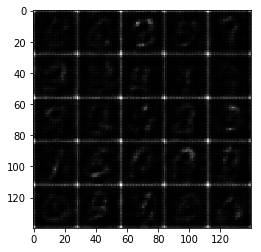

Epoch 1/2... Discriminator Loss: 1.5260... Generator Loss: 0.6219
Epoch 1/2... Discriminator Loss: 1.5212... Generator Loss: 0.5392
Epoch 1/2... Discriminator Loss: 1.5274... Generator Loss: 0.6294
Epoch 1/2... Discriminator Loss: 1.4247... Generator Loss: 0.7188
Epoch 1/2... Discriminator Loss: 1.6577... Generator Loss: 0.4098
Epoch 1/2... Discriminator Loss: 1.5639... Generator Loss: 0.5106
Epoch 1/2... Discriminator Loss: 1.4400... Generator Loss: 0.6435
Epoch 1/2... Discriminator Loss: 1.6037... Generator Loss: 0.4325
Epoch 1/2... Discriminator Loss: 1.4660... Generator Loss: 0.5877
Epoch 1/2... Discriminator Loss: 1.4490... Generator Loss: 0.6262


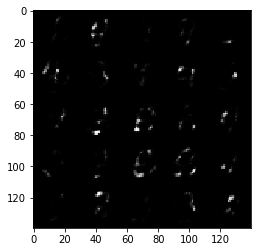

Epoch 1/2... Discriminator Loss: 1.4745... Generator Loss: 0.5764
Epoch 1/2... Discriminator Loss: 1.4965... Generator Loss: 0.5338
Epoch 1/2... Discriminator Loss: 1.5400... Generator Loss: 0.7204
Epoch 1/2... Discriminator Loss: 1.3983... Generator Loss: 0.7527
Epoch 1/2... Discriminator Loss: 1.4242... Generator Loss: 0.6160
Epoch 1/2... Discriminator Loss: 1.4667... Generator Loss: 0.7878
Epoch 1/2... Discriminator Loss: 1.4869... Generator Loss: 0.4997
Epoch 1/2... Discriminator Loss: 1.4546... Generator Loss: 0.5847
Epoch 1/2... Discriminator Loss: 1.4317... Generator Loss: 0.5978
Epoch 1/2... Discriminator Loss: 1.3795... Generator Loss: 0.7225


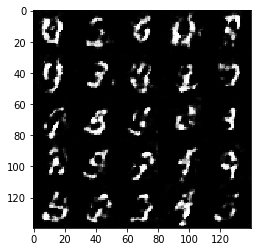

Epoch 1/2... Discriminator Loss: 1.4633... Generator Loss: 0.5907
Epoch 1/2... Discriminator Loss: 1.3925... Generator Loss: 0.7201
Epoch 1/2... Discriminator Loss: 1.5002... Generator Loss: 0.4956
Epoch 1/2... Discriminator Loss: 1.4962... Generator Loss: 0.4990
Epoch 1/2... Discriminator Loss: 1.4843... Generator Loss: 0.5531
Epoch 1/2... Discriminator Loss: 1.4831... Generator Loss: 0.5925
Epoch 1/2... Discriminator Loss: 1.3862... Generator Loss: 0.6743
Epoch 1/2... Discriminator Loss: 1.4544... Generator Loss: 0.5950
Epoch 1/2... Discriminator Loss: 1.4158... Generator Loss: 0.6144
Epoch 1/2... Discriminator Loss: 1.3735... Generator Loss: 0.7397


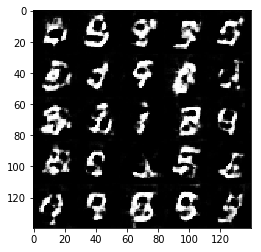

Epoch 1/2... Discriminator Loss: 1.3973... Generator Loss: 0.9263
Epoch 1/2... Discriminator Loss: 1.4541... Generator Loss: 1.2765
Epoch 1/2... Discriminator Loss: 1.4368... Generator Loss: 0.9859
Epoch 1/2... Discriminator Loss: 1.4274... Generator Loss: 1.0169
Epoch 1/2... Discriminator Loss: 1.3422... Generator Loss: 0.8682
Epoch 1/2... Discriminator Loss: 1.4038... Generator Loss: 0.8848
Epoch 1/2... Discriminator Loss: 1.4131... Generator Loss: 1.1238
Epoch 1/2... Discriminator Loss: 1.4362... Generator Loss: 0.7712
Epoch 1/2... Discriminator Loss: 1.4211... Generator Loss: 0.6266
Epoch 1/2... Discriminator Loss: 1.3739... Generator Loss: 0.8107


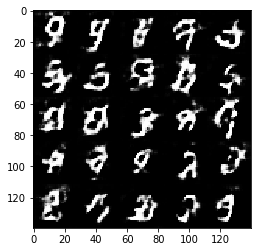

Epoch 1/2... Discriminator Loss: 1.4148... Generator Loss: 0.7006
Epoch 1/2... Discriminator Loss: 1.4909... Generator Loss: 0.5026
Epoch 1/2... Discriminator Loss: 1.4513... Generator Loss: 0.5906
Epoch 1/2... Discriminator Loss: 1.4876... Generator Loss: 0.5247
Epoch 1/2... Discriminator Loss: 1.4632... Generator Loss: 0.5708
Epoch 1/2... Discriminator Loss: 1.4506... Generator Loss: 0.6339
Epoch 1/2... Discriminator Loss: 1.3698... Generator Loss: 0.6767
Epoch 1/2... Discriminator Loss: 1.4749... Generator Loss: 0.5255
Epoch 1/2... Discriminator Loss: 1.4620... Generator Loss: 0.6098
Epoch 1/2... Discriminator Loss: 1.4016... Generator Loss: 0.7323


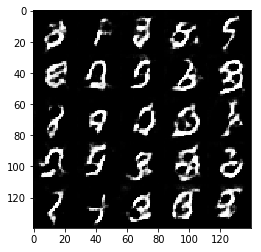

Epoch 1/2... Discriminator Loss: 1.3700... Generator Loss: 0.7613
Epoch 1/2... Discriminator Loss: 1.3680... Generator Loss: 0.7057
Epoch 1/2... Discriminator Loss: 1.3454... Generator Loss: 0.9368
Epoch 1/2... Discriminator Loss: 1.4563... Generator Loss: 1.2284
Epoch 1/2... Discriminator Loss: 1.4702... Generator Loss: 1.2034
Epoch 1/2... Discriminator Loss: 1.4022... Generator Loss: 1.0370
Epoch 1/2... Discriminator Loss: 1.4017... Generator Loss: 1.0565
Epoch 1/2... Discriminator Loss: 1.3864... Generator Loss: 0.9060
Epoch 1/2... Discriminator Loss: 1.4081... Generator Loss: 0.5969
Epoch 1/2... Discriminator Loss: 1.3550... Generator Loss: 0.8789


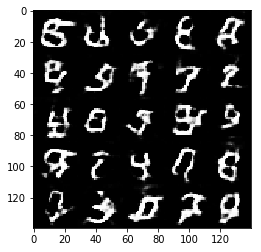

Epoch 1/2... Discriminator Loss: 1.3968... Generator Loss: 0.8880
Epoch 1/2... Discriminator Loss: 1.4047... Generator Loss: 0.7604
Epoch 1/2... Discriminator Loss: 1.4245... Generator Loss: 0.6073
Epoch 1/2... Discriminator Loss: 1.4082... Generator Loss: 0.6039
Epoch 1/2... Discriminator Loss: 1.3954... Generator Loss: 0.8785
Epoch 1/2... Discriminator Loss: 1.4152... Generator Loss: 0.7011
Epoch 1/2... Discriminator Loss: 1.4094... Generator Loss: 0.6595
Epoch 1/2... Discriminator Loss: 1.4143... Generator Loss: 0.6528
Epoch 1/2... Discriminator Loss: 1.4511... Generator Loss: 0.5570
Epoch 1/2... Discriminator Loss: 1.3962... Generator Loss: 0.6598


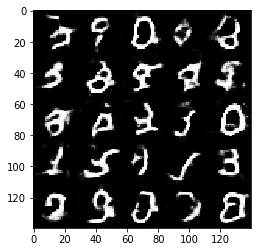

Epoch 1/2... Discriminator Loss: 1.4268... Generator Loss: 1.1302
Epoch 1/2... Discriminator Loss: 1.4098... Generator Loss: 0.9427
Epoch 1/2... Discriminator Loss: 1.3530... Generator Loss: 0.7772
Epoch 1/2... Discriminator Loss: 1.4211... Generator Loss: 0.8245
Epoch 1/2... Discriminator Loss: 1.4283... Generator Loss: 0.9050
Epoch 1/2... Discriminator Loss: 1.3955... Generator Loss: 0.7388
Epoch 1/2... Discriminator Loss: 1.4273... Generator Loss: 0.5971
Epoch 1/2... Discriminator Loss: 1.3960... Generator Loss: 0.7224
Epoch 1/2... Discriminator Loss: 1.4411... Generator Loss: 0.5766
Epoch 1/2... Discriminator Loss: 1.4621... Generator Loss: 0.5552


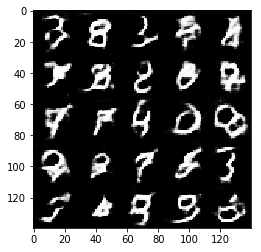

Epoch 1/2... Discriminator Loss: 1.4220... Generator Loss: 0.6575
Epoch 1/2... Discriminator Loss: 1.3627... Generator Loss: 1.0154
Epoch 1/2... Discriminator Loss: 1.4187... Generator Loss: 0.8526
Epoch 1/2... Discriminator Loss: 1.4135... Generator Loss: 1.0245
Epoch 1/2... Discriminator Loss: 1.4195... Generator Loss: 0.9356
Epoch 1/2... Discriminator Loss: 1.4362... Generator Loss: 1.0267
Epoch 1/2... Discriminator Loss: 1.4213... Generator Loss: 1.1528
Epoch 1/2... Discriminator Loss: 1.3736... Generator Loss: 0.8744
Epoch 1/2... Discriminator Loss: 1.4155... Generator Loss: 0.6991
Epoch 1/2... Discriminator Loss: 1.4030... Generator Loss: 0.7502


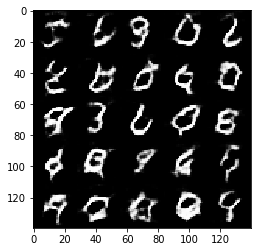

Epoch 1/2... Discriminator Loss: 1.4280... Generator Loss: 1.0306
Epoch 1/2... Discriminator Loss: 1.4010... Generator Loss: 0.9524
Epoch 1/2... Discriminator Loss: 1.4656... Generator Loss: 1.1671
Epoch 1/2... Discriminator Loss: 1.4104... Generator Loss: 1.0533
Epoch 1/2... Discriminator Loss: 1.3699... Generator Loss: 1.0314
Epoch 1/2... Discriminator Loss: 1.3873... Generator Loss: 0.8857
Epoch 1/2... Discriminator Loss: 1.3990... Generator Loss: 0.8514
Epoch 1/2... Discriminator Loss: 1.3716... Generator Loss: 0.6905
Epoch 1/2... Discriminator Loss: 1.4199... Generator Loss: 0.5839
Epoch 1/2... Discriminator Loss: 1.4296... Generator Loss: 0.5806


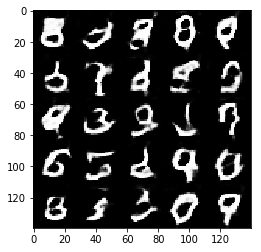

Epoch 1/2... Discriminator Loss: 1.3727... Generator Loss: 0.8678
Epoch 1/2... Discriminator Loss: 1.3527... Generator Loss: 0.9286
Epoch 1/2... Discriminator Loss: 1.3799... Generator Loss: 0.6835
Epoch 1/2... Discriminator Loss: 1.3826... Generator Loss: 0.8577
Epoch 1/2... Discriminator Loss: 1.4270... Generator Loss: 0.9016
Epoch 1/2... Discriminator Loss: 1.4101... Generator Loss: 0.9077
Epoch 1/2... Discriminator Loss: 1.5043... Generator Loss: 1.3161
Epoch 1/2... Discriminator Loss: 1.3903... Generator Loss: 0.9316
Epoch 1/2... Discriminator Loss: 1.3769... Generator Loss: 0.7290
Epoch 1/2... Discriminator Loss: 1.4065... Generator Loss: 0.5896


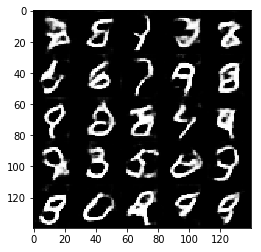

Epoch 1/2... Discriminator Loss: 1.3627... Generator Loss: 0.7258
Epoch 1/2... Discriminator Loss: 1.4253... Generator Loss: 0.6782
Epoch 1/2... Discriminator Loss: 1.4186... Generator Loss: 0.7385
Epoch 1/2... Discriminator Loss: 1.3943... Generator Loss: 0.6771
Epoch 1/2... Discriminator Loss: 1.3701... Generator Loss: 0.8646
Epoch 1/2... Discriminator Loss: 1.3731... Generator Loss: 0.7245
Epoch 1/2... Discriminator Loss: 1.3667... Generator Loss: 0.6724
Epoch 1/2... Discriminator Loss: 1.3846... Generator Loss: 0.6629
Epoch 1/2... Discriminator Loss: 1.4364... Generator Loss: 0.5751
Epoch 1/2... Discriminator Loss: 1.4127... Generator Loss: 0.6089


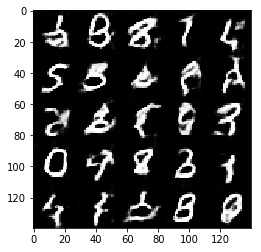

Epoch 1/2... Discriminator Loss: 1.4087... Generator Loss: 0.6308
Epoch 1/2... Discriminator Loss: 1.4385... Generator Loss: 0.7800
Epoch 1/2... Discriminator Loss: 1.3725... Generator Loss: 0.7592
Epoch 1/2... Discriminator Loss: 1.4333... Generator Loss: 1.0653
Epoch 1/2... Discriminator Loss: 1.4003... Generator Loss: 0.9503
Epoch 1/2... Discriminator Loss: 1.3550... Generator Loss: 0.9180
Epoch 1/2... Discriminator Loss: 1.3928... Generator Loss: 0.6674
Epoch 1/2... Discriminator Loss: 1.3762... Generator Loss: 0.6891
Epoch 1/2... Discriminator Loss: 1.4011... Generator Loss: 0.6593
Epoch 1/2... Discriminator Loss: 1.3843... Generator Loss: 0.6926


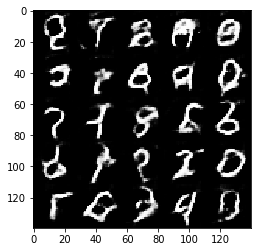

Epoch 1/2... Discriminator Loss: 1.3913... Generator Loss: 0.8110
Epoch 1/2... Discriminator Loss: 1.3524... Generator Loss: 0.8415
Epoch 1/2... Discriminator Loss: 1.3666... Generator Loss: 0.9696
Epoch 1/2... Discriminator Loss: 1.4208... Generator Loss: 1.0934
Epoch 1/2... Discriminator Loss: 1.3968... Generator Loss: 0.9724
Epoch 1/2... Discriminator Loss: 1.4059... Generator Loss: 1.1014
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.8556
Epoch 1/2... Discriminator Loss: 1.3910... Generator Loss: 0.8384
Epoch 1/2... Discriminator Loss: 1.3601... Generator Loss: 0.9912
Epoch 1/2... Discriminator Loss: 1.3920... Generator Loss: 0.7953


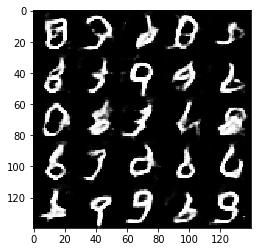

Epoch 1/2... Discriminator Loss: 1.3702... Generator Loss: 0.8445
Epoch 1/2... Discriminator Loss: 1.4791... Generator Loss: 1.1424
Epoch 1/2... Discriminator Loss: 1.4428... Generator Loss: 1.1042
Epoch 1/2... Discriminator Loss: 1.3631... Generator Loss: 0.8825
Epoch 1/2... Discriminator Loss: 1.4182... Generator Loss: 0.9831
Epoch 1/2... Discriminator Loss: 1.4316... Generator Loss: 0.8984
Epoch 1/2... Discriminator Loss: 1.3919... Generator Loss: 0.9894
Epoch 1/2... Discriminator Loss: 1.3916... Generator Loss: 0.7438
Epoch 1/2... Discriminator Loss: 1.3315... Generator Loss: 0.7779
Epoch 1/2... Discriminator Loss: 1.3769... Generator Loss: 0.6817


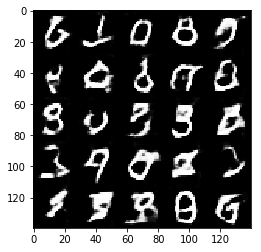

Epoch 1/2... Discriminator Loss: 1.3748... Generator Loss: 0.7089
Epoch 1/2... Discriminator Loss: 1.3851... Generator Loss: 0.6641
Epoch 1/2... Discriminator Loss: 1.4438... Generator Loss: 0.5396
Epoch 1/2... Discriminator Loss: 1.3865... Generator Loss: 0.7223
Epoch 1/2... Discriminator Loss: 1.4165... Generator Loss: 0.7570
Epoch 1/2... Discriminator Loss: 1.3996... Generator Loss: 0.9374
Epoch 1/2... Discriminator Loss: 1.3937... Generator Loss: 0.8945
Epoch 1/2... Discriminator Loss: 1.4341... Generator Loss: 0.9782
Epoch 1/2... Discriminator Loss: 1.3651... Generator Loss: 0.7881
Epoch 1/2... Discriminator Loss: 1.3897... Generator Loss: 1.0478


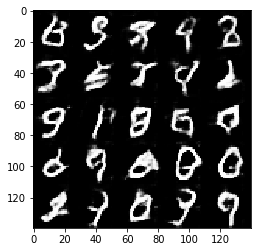

Epoch 1/2... Discriminator Loss: 1.3884... Generator Loss: 0.9648
Epoch 1/2... Discriminator Loss: 1.3640... Generator Loss: 0.8407
Epoch 1/2... Discriminator Loss: 1.3577... Generator Loss: 0.8591
Epoch 1/2... Discriminator Loss: 1.3915... Generator Loss: 0.9070
Epoch 1/2... Discriminator Loss: 1.3741... Generator Loss: 0.8544
Epoch 1/2... Discriminator Loss: 1.3608... Generator Loss: 0.8220
Epoch 1/2... Discriminator Loss: 1.4578... Generator Loss: 1.1311
Epoch 1/2... Discriminator Loss: 1.3802... Generator Loss: 0.8897
Epoch 1/2... Discriminator Loss: 1.4046... Generator Loss: 1.0898
Epoch 1/2... Discriminator Loss: 1.4564... Generator Loss: 1.1713


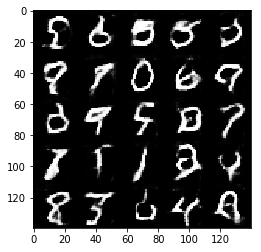

Epoch 1/2... Discriminator Loss: 1.3484... Generator Loss: 0.9481
Epoch 1/2... Discriminator Loss: 1.3564... Generator Loss: 0.9885
Epoch 1/2... Discriminator Loss: 1.3470... Generator Loss: 0.9390
Epoch 1/2... Discriminator Loss: 1.3314... Generator Loss: 0.9018
Epoch 1/2... Discriminator Loss: 1.3323... Generator Loss: 0.9030
Epoch 1/2... Discriminator Loss: 1.4057... Generator Loss: 0.8385
Epoch 1/2... Discriminator Loss: 1.3904... Generator Loss: 1.0258
Epoch 2/2... Discriminator Loss: 1.4266... Generator Loss: 0.7274
Epoch 2/2... Discriminator Loss: 1.3433... Generator Loss: 0.8785
Epoch 2/2... Discriminator Loss: 1.3933... Generator Loss: 0.8165


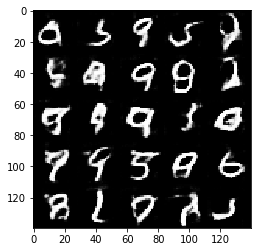

Epoch 2/2... Discriminator Loss: 1.3848... Generator Loss: 0.9258
Epoch 2/2... Discriminator Loss: 1.3987... Generator Loss: 0.9193
Epoch 2/2... Discriminator Loss: 1.3440... Generator Loss: 0.8150
Epoch 2/2... Discriminator Loss: 1.4396... Generator Loss: 0.5679
Epoch 2/2... Discriminator Loss: 1.4460... Generator Loss: 0.6081
Epoch 2/2... Discriminator Loss: 1.3598... Generator Loss: 0.8650
Epoch 2/2... Discriminator Loss: 1.3613... Generator Loss: 0.9070
Epoch 2/2... Discriminator Loss: 1.4017... Generator Loss: 1.0725
Epoch 2/2... Discriminator Loss: 1.3734... Generator Loss: 0.9272
Epoch 2/2... Discriminator Loss: 1.3594... Generator Loss: 0.7485


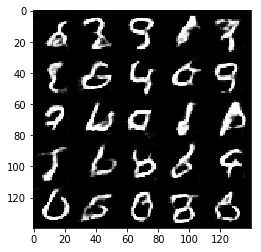

Epoch 2/2... Discriminator Loss: 1.3678... Generator Loss: 0.7226
Epoch 2/2... Discriminator Loss: 1.3931... Generator Loss: 0.6955
Epoch 2/2... Discriminator Loss: 1.3781... Generator Loss: 0.6790
Epoch 2/2... Discriminator Loss: 1.3893... Generator Loss: 0.6188
Epoch 2/2... Discriminator Loss: 1.4061... Generator Loss: 0.6522
Epoch 2/2... Discriminator Loss: 1.3604... Generator Loss: 0.7271
Epoch 2/2... Discriminator Loss: 1.3424... Generator Loss: 0.8252
Epoch 2/2... Discriminator Loss: 1.3468... Generator Loss: 0.8495
Epoch 2/2... Discriminator Loss: 1.3953... Generator Loss: 0.8789
Epoch 2/2... Discriminator Loss: 1.4450... Generator Loss: 1.1179


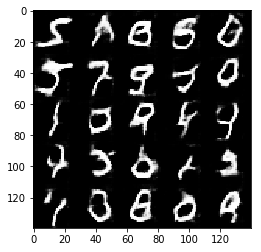

Epoch 2/2... Discriminator Loss: 1.4023... Generator Loss: 0.8513
Epoch 2/2... Discriminator Loss: 1.3759... Generator Loss: 0.8777
Epoch 2/2... Discriminator Loss: 1.4182... Generator Loss: 1.0761
Epoch 2/2... Discriminator Loss: 1.4100... Generator Loss: 1.0397
Epoch 2/2... Discriminator Loss: 1.3740... Generator Loss: 0.8097
Epoch 2/2... Discriminator Loss: 1.3748... Generator Loss: 0.7600
Epoch 2/2... Discriminator Loss: 1.4107... Generator Loss: 0.6121
Epoch 2/2... Discriminator Loss: 1.3724... Generator Loss: 0.6479
Epoch 2/2... Discriminator Loss: 1.4222... Generator Loss: 0.6371
Epoch 2/2... Discriminator Loss: 1.4016... Generator Loss: 0.7742


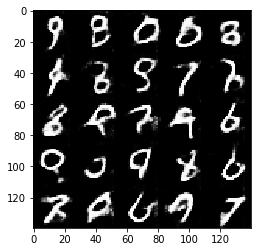

Epoch 2/2... Discriminator Loss: 1.3824... Generator Loss: 0.7698
Epoch 2/2... Discriminator Loss: 1.3525... Generator Loss: 0.7806
Epoch 2/2... Discriminator Loss: 1.3820... Generator Loss: 0.6430
Epoch 2/2... Discriminator Loss: 1.3836... Generator Loss: 0.6563
Epoch 2/2... Discriminator Loss: 1.4370... Generator Loss: 0.7152
Epoch 2/2... Discriminator Loss: 1.3790... Generator Loss: 0.6832
Epoch 2/2... Discriminator Loss: 1.3501... Generator Loss: 0.8084
Epoch 2/2... Discriminator Loss: 1.4088... Generator Loss: 0.6635
Epoch 2/2... Discriminator Loss: 1.4491... Generator Loss: 0.6396
Epoch 2/2... Discriminator Loss: 1.4029... Generator Loss: 0.7175


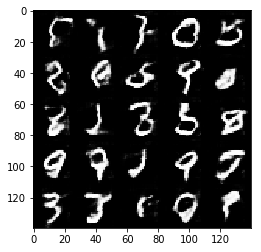

Epoch 2/2... Discriminator Loss: 1.4109... Generator Loss: 0.6199
Epoch 2/2... Discriminator Loss: 1.3900... Generator Loss: 0.6350
Epoch 2/2... Discriminator Loss: 1.4006... Generator Loss: 0.6619
Epoch 2/2... Discriminator Loss: 1.4150... Generator Loss: 0.6118
Epoch 2/2... Discriminator Loss: 1.3715... Generator Loss: 0.9243
Epoch 2/2... Discriminator Loss: 1.4216... Generator Loss: 1.0220
Epoch 2/2... Discriminator Loss: 1.4144... Generator Loss: 0.9704
Epoch 2/2... Discriminator Loss: 1.3827... Generator Loss: 0.7794
Epoch 2/2... Discriminator Loss: 1.4258... Generator Loss: 0.8319
Epoch 2/2... Discriminator Loss: 1.3759... Generator Loss: 0.8660


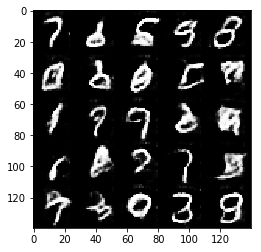

Epoch 2/2... Discriminator Loss: 1.3604... Generator Loss: 0.7679
Epoch 2/2... Discriminator Loss: 1.4101... Generator Loss: 0.6096
Epoch 2/2... Discriminator Loss: 1.3587... Generator Loss: 0.7964
Epoch 2/2... Discriminator Loss: 1.3714... Generator Loss: 0.9141
Epoch 2/2... Discriminator Loss: 1.3496... Generator Loss: 1.0167
Epoch 2/2... Discriminator Loss: 1.3962... Generator Loss: 0.9436
Epoch 2/2... Discriminator Loss: 1.4051... Generator Loss: 1.0244
Epoch 2/2... Discriminator Loss: 1.3807... Generator Loss: 0.8222
Epoch 2/2... Discriminator Loss: 1.3825... Generator Loss: 0.8998
Epoch 2/2... Discriminator Loss: 1.3449... Generator Loss: 0.9136


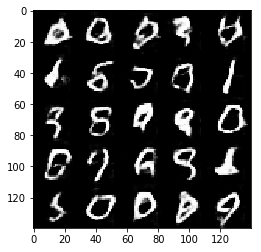

Epoch 2/2... Discriminator Loss: 1.3974... Generator Loss: 0.9654
Epoch 2/2... Discriminator Loss: 1.4000... Generator Loss: 0.6191
Epoch 2/2... Discriminator Loss: 1.4099... Generator Loss: 0.5734
Epoch 2/2... Discriminator Loss: 1.3833... Generator Loss: 0.7357
Epoch 2/2... Discriminator Loss: 1.3691... Generator Loss: 0.7329
Epoch 2/2... Discriminator Loss: 1.3906... Generator Loss: 0.8419
Epoch 2/2... Discriminator Loss: 1.3646... Generator Loss: 0.7015
Epoch 2/2... Discriminator Loss: 1.4091... Generator Loss: 0.6984
Epoch 2/2... Discriminator Loss: 1.4572... Generator Loss: 1.1110
Epoch 2/2... Discriminator Loss: 1.4102... Generator Loss: 1.1128


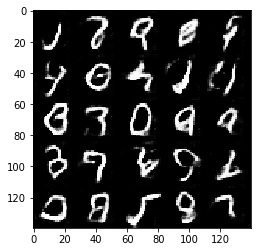

Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.9085
Epoch 2/2... Discriminator Loss: 1.3783... Generator Loss: 1.0051
Epoch 2/2... Discriminator Loss: 1.3449... Generator Loss: 0.8499
Epoch 2/2... Discriminator Loss: 1.4071... Generator Loss: 0.7837
Epoch 2/2... Discriminator Loss: 1.3140... Generator Loss: 0.8384
Epoch 2/2... Discriminator Loss: 1.3434... Generator Loss: 0.8249
Epoch 2/2... Discriminator Loss: 1.3929... Generator Loss: 0.6643
Epoch 2/2... Discriminator Loss: 1.4266... Generator Loss: 0.6170
Epoch 2/2... Discriminator Loss: 1.3893... Generator Loss: 0.6547
Epoch 2/2... Discriminator Loss: 1.3634... Generator Loss: 0.6904


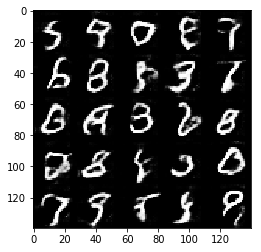

Epoch 2/2... Discriminator Loss: 1.3582... Generator Loss: 0.7135
Epoch 2/2... Discriminator Loss: 1.3746... Generator Loss: 0.6263
Epoch 2/2... Discriminator Loss: 1.3611... Generator Loss: 0.8685
Epoch 2/2... Discriminator Loss: 1.3578... Generator Loss: 0.8589
Epoch 2/2... Discriminator Loss: 1.3760... Generator Loss: 0.8826
Epoch 2/2... Discriminator Loss: 1.3484... Generator Loss: 0.8584
Epoch 2/2... Discriminator Loss: 1.4130... Generator Loss: 1.0472
Epoch 2/2... Discriminator Loss: 1.4236... Generator Loss: 1.0649
Epoch 2/2... Discriminator Loss: 1.3985... Generator Loss: 0.8501
Epoch 2/2... Discriminator Loss: 1.4038... Generator Loss: 0.9188


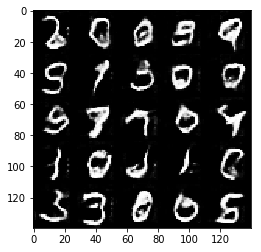

Epoch 2/2... Discriminator Loss: 1.3563... Generator Loss: 0.7170
Epoch 2/2... Discriminator Loss: 1.3904... Generator Loss: 0.6855
Epoch 2/2... Discriminator Loss: 1.3395... Generator Loss: 0.8364
Epoch 2/2... Discriminator Loss: 1.4242... Generator Loss: 0.7491
Epoch 2/2... Discriminator Loss: 1.4263... Generator Loss: 0.5988
Epoch 2/2... Discriminator Loss: 1.3852... Generator Loss: 0.7997
Epoch 2/2... Discriminator Loss: 1.3930... Generator Loss: 0.8355
Epoch 2/2... Discriminator Loss: 1.3652... Generator Loss: 0.7997
Epoch 2/2... Discriminator Loss: 1.3621... Generator Loss: 0.7934
Epoch 2/2... Discriminator Loss: 1.3754... Generator Loss: 0.6847


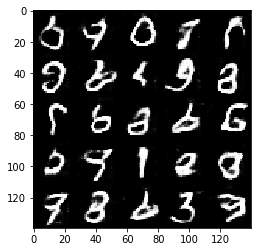

Epoch 2/2... Discriminator Loss: 1.3972... Generator Loss: 0.6454
Epoch 2/2... Discriminator Loss: 1.3885... Generator Loss: 0.6966
Epoch 2/2... Discriminator Loss: 1.4325... Generator Loss: 0.8421
Epoch 2/2... Discriminator Loss: 1.3699... Generator Loss: 0.8077
Epoch 2/2... Discriminator Loss: 1.3753... Generator Loss: 0.7175
Epoch 2/2... Discriminator Loss: 1.3733... Generator Loss: 0.7228
Epoch 2/2... Discriminator Loss: 1.3576... Generator Loss: 0.7733
Epoch 2/2... Discriminator Loss: 1.4390... Generator Loss: 1.0074
Epoch 2/2... Discriminator Loss: 1.3521... Generator Loss: 0.9208
Epoch 2/2... Discriminator Loss: 1.3555... Generator Loss: 0.9300


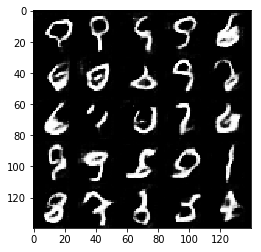

Epoch 2/2... Discriminator Loss: 1.3798... Generator Loss: 0.9861
Epoch 2/2... Discriminator Loss: 1.3905... Generator Loss: 0.9476
Epoch 2/2... Discriminator Loss: 1.4208... Generator Loss: 0.9711
Epoch 2/2... Discriminator Loss: 1.3847... Generator Loss: 0.8613
Epoch 2/2... Discriminator Loss: 1.3684... Generator Loss: 0.8482
Epoch 2/2... Discriminator Loss: 1.3323... Generator Loss: 0.9062
Epoch 2/2... Discriminator Loss: 1.4037... Generator Loss: 0.9769
Epoch 2/2... Discriminator Loss: 1.3455... Generator Loss: 0.8257
Epoch 2/2... Discriminator Loss: 1.3594... Generator Loss: 0.9137
Epoch 2/2... Discriminator Loss: 1.4067... Generator Loss: 1.0066


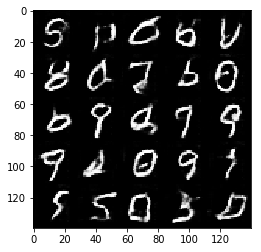

Epoch 2/2... Discriminator Loss: 1.3928... Generator Loss: 1.0044
Epoch 2/2... Discriminator Loss: 1.3603... Generator Loss: 0.8342
Epoch 2/2... Discriminator Loss: 1.4276... Generator Loss: 0.8253
Epoch 2/2... Discriminator Loss: 1.3798... Generator Loss: 0.8410
Epoch 2/2... Discriminator Loss: 1.4058... Generator Loss: 0.9946
Epoch 2/2... Discriminator Loss: 1.3836... Generator Loss: 0.8490
Epoch 2/2... Discriminator Loss: 1.3720... Generator Loss: 0.7911
Epoch 2/2... Discriminator Loss: 1.3790... Generator Loss: 0.6695
Epoch 2/2... Discriminator Loss: 1.4692... Generator Loss: 0.7893
Epoch 2/2... Discriminator Loss: 1.3907... Generator Loss: 0.6906


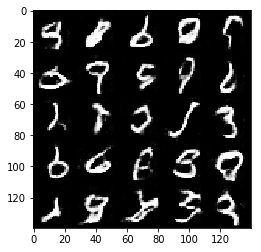

Epoch 2/2... Discriminator Loss: 1.3907... Generator Loss: 0.6417
Epoch 2/2... Discriminator Loss: 1.3726... Generator Loss: 0.6859
Epoch 2/2... Discriminator Loss: 1.4566... Generator Loss: 0.5918
Epoch 2/2... Discriminator Loss: 1.3225... Generator Loss: 0.8014
Epoch 2/2... Discriminator Loss: 1.3839... Generator Loss: 0.9247
Epoch 2/2... Discriminator Loss: 1.4339... Generator Loss: 1.1160
Epoch 2/2... Discriminator Loss: 1.4003... Generator Loss: 1.0623
Epoch 2/2... Discriminator Loss: 1.3448... Generator Loss: 0.8442
Epoch 2/2... Discriminator Loss: 1.3790... Generator Loss: 0.8034
Epoch 2/2... Discriminator Loss: 1.3915... Generator Loss: 0.8341


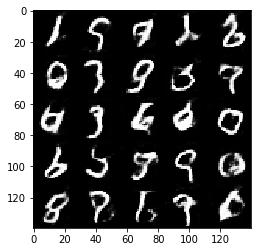

Epoch 2/2... Discriminator Loss: 1.4117... Generator Loss: 0.9349
Epoch 2/2... Discriminator Loss: 1.3532... Generator Loss: 0.8496
Epoch 2/2... Discriminator Loss: 1.3888... Generator Loss: 0.6808
Epoch 2/2... Discriminator Loss: 1.4504... Generator Loss: 0.7159
Epoch 2/2... Discriminator Loss: 1.3440... Generator Loss: 0.7563
Epoch 2/2... Discriminator Loss: 1.3541... Generator Loss: 1.1133
Epoch 2/2... Discriminator Loss: 1.3983... Generator Loss: 0.9727
Epoch 2/2... Discriminator Loss: 1.3257... Generator Loss: 0.9008
Epoch 2/2... Discriminator Loss: 1.3827... Generator Loss: 0.7694
Epoch 2/2... Discriminator Loss: 1.3775... Generator Loss: 0.8938


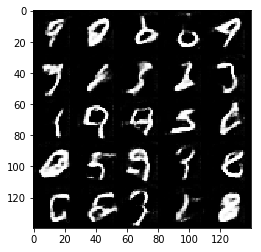

Epoch 2/2... Discriminator Loss: 1.3680... Generator Loss: 0.8624
Epoch 2/2... Discriminator Loss: 1.3799... Generator Loss: 0.9164
Epoch 2/2... Discriminator Loss: 1.4131... Generator Loss: 1.0411
Epoch 2/2... Discriminator Loss: 1.3728... Generator Loss: 0.9735
Epoch 2/2... Discriminator Loss: 1.4048... Generator Loss: 1.0054
Epoch 2/2... Discriminator Loss: 1.3447... Generator Loss: 0.9168
Epoch 2/2... Discriminator Loss: 1.3529... Generator Loss: 0.9639
Epoch 2/2... Discriminator Loss: 1.3944... Generator Loss: 0.7947
Epoch 2/2... Discriminator Loss: 1.3575... Generator Loss: 0.7150
Epoch 2/2... Discriminator Loss: 1.3756... Generator Loss: 0.7371


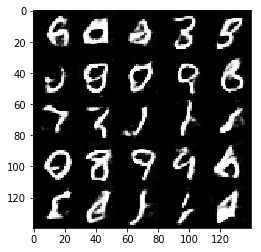

Epoch 2/2... Discriminator Loss: 1.3756... Generator Loss: 0.7925
Epoch 2/2... Discriminator Loss: 1.3830... Generator Loss: 0.9129
Epoch 2/2... Discriminator Loss: 1.3486... Generator Loss: 0.8628
Epoch 2/2... Discriminator Loss: 1.4129... Generator Loss: 0.7645
Epoch 2/2... Discriminator Loss: 1.3885... Generator Loss: 0.7046
Epoch 2/2... Discriminator Loss: 1.3854... Generator Loss: 0.7288
Epoch 2/2... Discriminator Loss: 1.3660... Generator Loss: 0.7608
Epoch 2/2... Discriminator Loss: 1.4365... Generator Loss: 0.5751
Epoch 2/2... Discriminator Loss: 1.3933... Generator Loss: 0.7774
Epoch 2/2... Discriminator Loss: 1.3964... Generator Loss: 0.7002


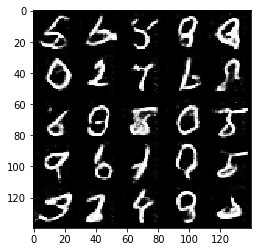

Epoch 2/2... Discriminator Loss: 1.3565... Generator Loss: 0.6912
Epoch 2/2... Discriminator Loss: 1.3760... Generator Loss: 0.7453
Epoch 2/2... Discriminator Loss: 1.3808... Generator Loss: 0.7827
Epoch 2/2... Discriminator Loss: 1.3642... Generator Loss: 0.7383
Epoch 2/2... Discriminator Loss: 1.3324... Generator Loss: 0.8433
Epoch 2/2... Discriminator Loss: 1.3756... Generator Loss: 0.7443
Epoch 2/2... Discriminator Loss: 1.3805... Generator Loss: 0.6833
Epoch 2/2... Discriminator Loss: 1.3809... Generator Loss: 0.6617
Epoch 2/2... Discriminator Loss: 1.4022... Generator Loss: 0.7708
Epoch 2/2... Discriminator Loss: 1.4108... Generator Loss: 0.5896


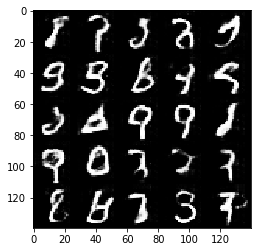

Epoch 2/2... Discriminator Loss: 1.3524... Generator Loss: 0.7367
Epoch 2/2... Discriminator Loss: 1.3883... Generator Loss: 0.7200
Epoch 2/2... Discriminator Loss: 1.3485... Generator Loss: 0.8482
Epoch 2/2... Discriminator Loss: 1.3802... Generator Loss: 0.9234
Epoch 2/2... Discriminator Loss: 1.3587... Generator Loss: 0.7178


In [57]:
batch_size = 32
z_dim = 64
learning_rate = 0.0005
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.0817... Generator Loss: 0.4938
Epoch 1/1... Discriminator Loss: 2.2594... Generator Loss: 0.3982
Epoch 1/1... Discriminator Loss: 1.9261... Generator Loss: 0.3525
Epoch 1/1... Discriminator Loss: 1.7763... Generator Loss: 0.5107
Epoch 1/1... Discriminator Loss: 1.9027... Generator Loss: 0.4169
Epoch 1/1... Discriminator Loss: 1.8845... Generator Loss: 0.3994
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 1.0011
Epoch 1/1... Discriminator Loss: 1.6858... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.6669... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.5767... Generator Loss: 0.6529


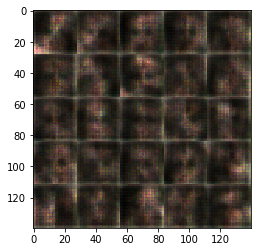

Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.6249... Generator Loss: 0.4455
Epoch 1/1... Discriminator Loss: 1.5500... Generator Loss: 0.6514
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 0.9046
Epoch 1/1... Discriminator Loss: 1.5086... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.5407... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.5102... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 1.5959... Generator Loss: 0.8890


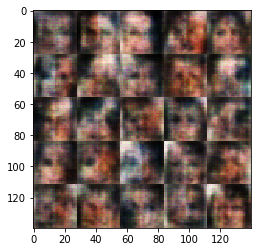

Epoch 1/1... Discriminator Loss: 1.5181... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.5860... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.6906... Generator Loss: 0.6219
Epoch 1/1... Discriminator Loss: 1.5751... Generator Loss: 0.5161
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.9649
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.5389... Generator Loss: 0.4953
Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.6872... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.6879


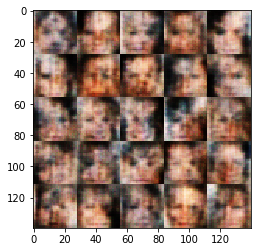

Epoch 1/1... Discriminator Loss: 1.5275... Generator Loss: 0.8928
Epoch 1/1... Discriminator Loss: 1.6285... Generator Loss: 0.5306
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.5503... Generator Loss: 0.9062
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.4781... Generator Loss: 0.8628
Epoch 1/1... Discriminator Loss: 1.5637... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 1.5150... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.6752


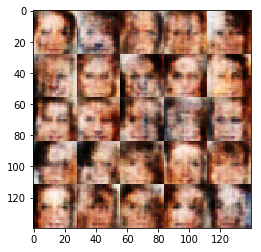

Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.9736
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.5237... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.5207... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 1.5085... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.5509... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.5952... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 1.6414... Generator Loss: 0.8086


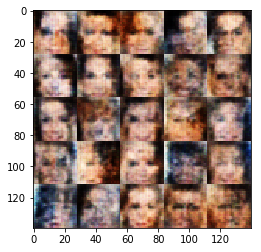

Epoch 1/1... Discriminator Loss: 1.5129... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.5333... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.5340... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.4884... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.5071... Generator Loss: 0.8915
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.7322


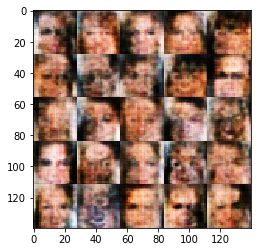

Epoch 1/1... Discriminator Loss: 1.5707... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.5599... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.8590
Epoch 1/1... Discriminator Loss: 1.5092... Generator Loss: 0.9449
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.8423
Epoch 1/1... Discriminator Loss: 1.5610... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.4998... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.9068
Epoch 1/1... Discriminator Loss: 1.5122... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 0.8558


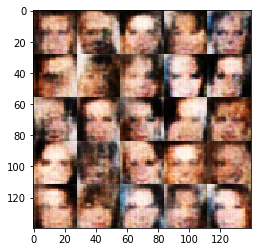

Epoch 1/1... Discriminator Loss: 1.6441... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.5023... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.4823... Generator Loss: 0.8746
Epoch 1/1... Discriminator Loss: 1.4695... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.5111... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.6921


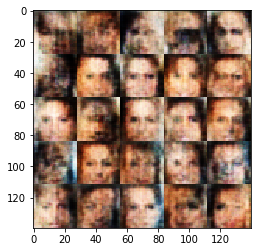

Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.9467
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.7259
Epoch 1/1... Discriminator Loss: 1.4882... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.6530
Epoch 1/1... Discriminator Loss: 1.4929... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.9140
Epoch 1/1... Discriminator Loss: 1.5906... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.5090... Generator Loss: 0.7732


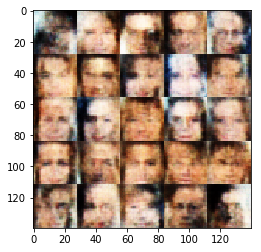

Epoch 1/1... Discriminator Loss: 1.4921... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.8816
Epoch 1/1... Discriminator Loss: 1.5009... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.8916
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.9826
Epoch 1/1... Discriminator Loss: 1.4966... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.7425


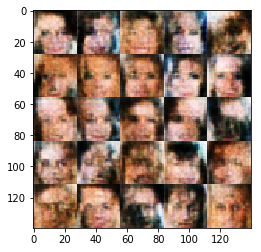

Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 0.8683
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.4790... Generator Loss: 0.8800
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 1.6399... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.4844... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.8007


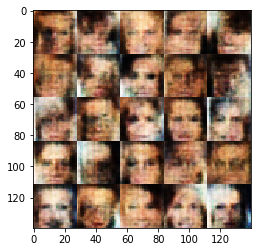

Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.8026


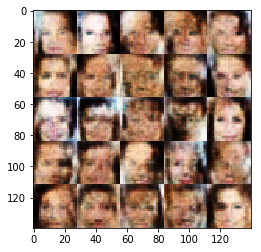

Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.9068
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.5683... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 1.4939... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.7372


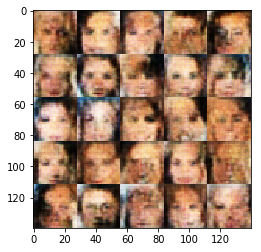

Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.5643... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.5117... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.5249... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.8221


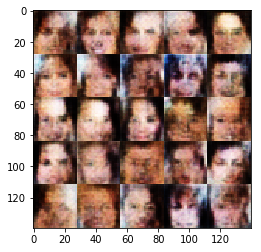

Epoch 1/1... Discriminator Loss: 1.4876... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.5914... Generator Loss: 0.8974
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.8182
Epoch 1/1... Discriminator Loss: 1.4735... Generator Loss: 0.8994
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.7150


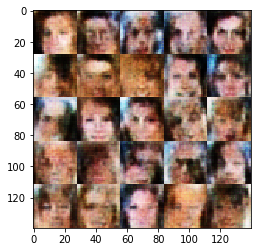

Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.4687... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.5936... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.9494
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.8245
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.8131


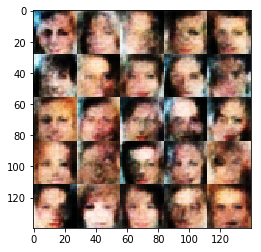

Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.5738... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.5364... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.8138


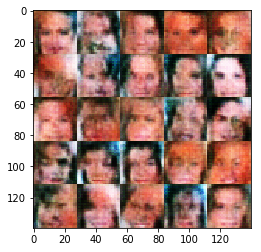

Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.9032
Epoch 1/1... Discriminator Loss: 1.5811... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.8893
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 1.5040... Generator Loss: 0.8451
Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 0.8629
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.6495... Generator Loss: 0.8518
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.7734


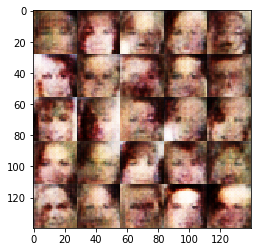

Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.4650... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.5066... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.4553... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.4951... Generator Loss: 0.7460


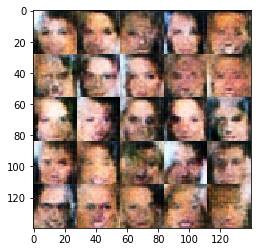

Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 0.8606
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.7288


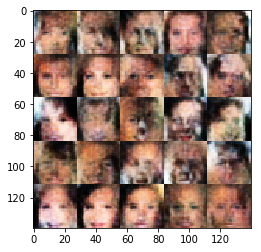

Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.8932
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.4867... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.4695... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.4767... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.7676


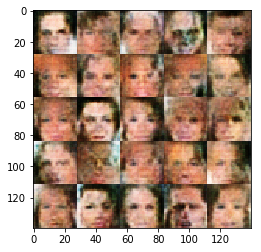

Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.7532
Epoch 1/1... Discriminator Loss: 1.4941... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.7335


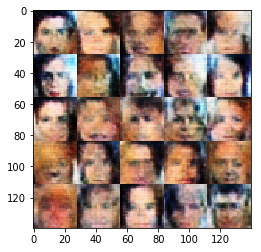

Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.8124


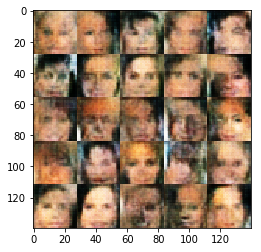

Epoch 1/1... Discriminator Loss: 1.6008... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.5120... Generator Loss: 0.7294
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.5302... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.7702


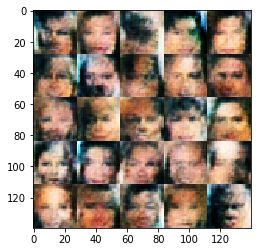

Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.8242


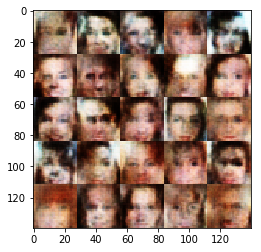

Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.5053... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7987


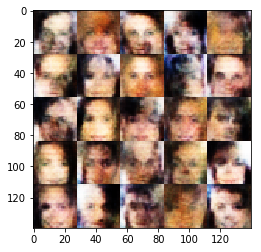

Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 1.5038... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.7955


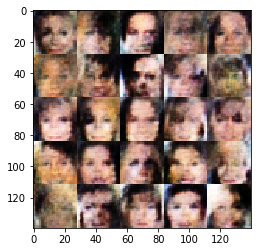

Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.8202
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.8310


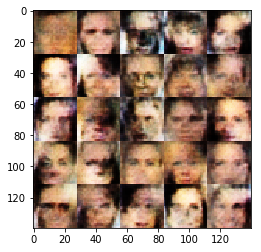

Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.5245... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.8107


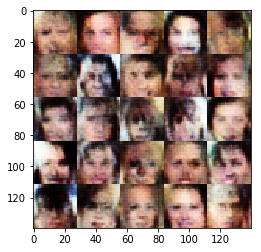

Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.8716
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.7738


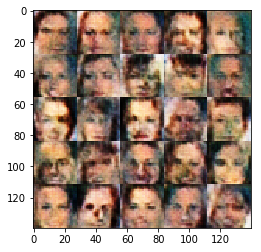

Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.7781


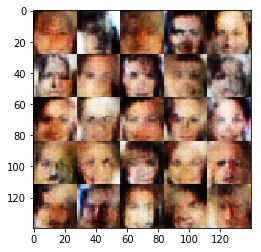

Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.8424
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.8367
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.7409


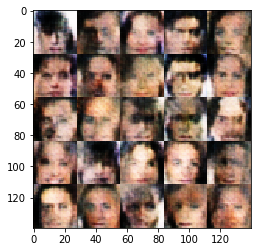

Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.7701


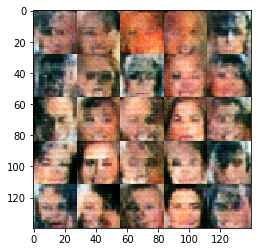

Epoch 1/1... Discriminator Loss: 1.4687... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.8268


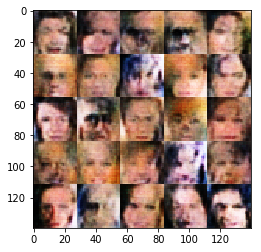

Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7766
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.7929


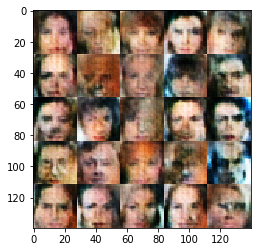

Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.4796... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.8841
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.7737


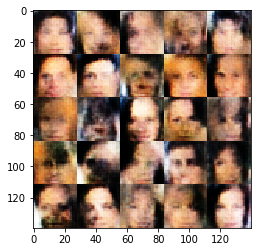

Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.4718... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7767


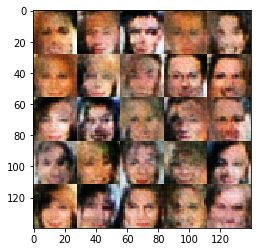

Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.7398


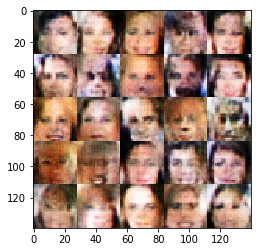

Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.7163


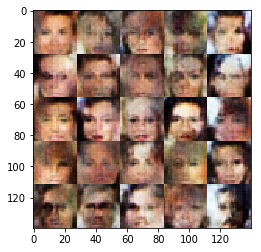

Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.7748


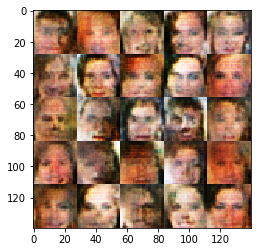

Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.7698


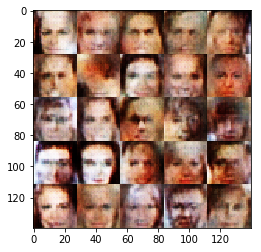

Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7484


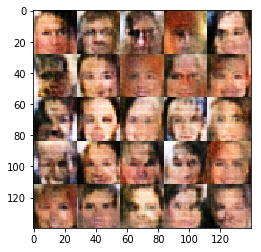

Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.8841
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.7955


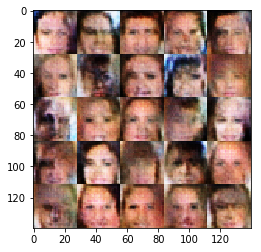

Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.7449


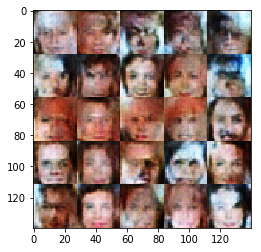

Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.4801... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.7664


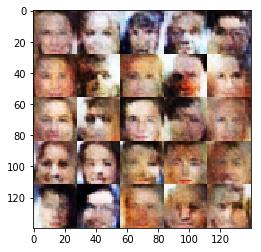

Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.8861
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.7806


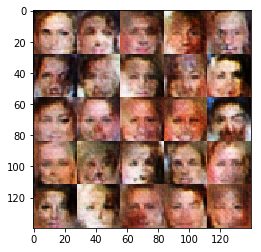

Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.8414


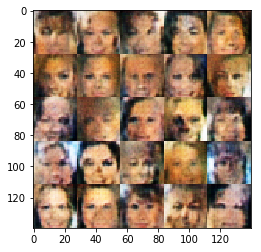

Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.7947


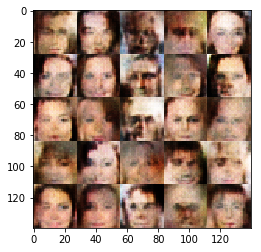

Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.8366
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.7465


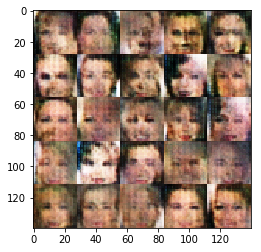

Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.8424
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.7917


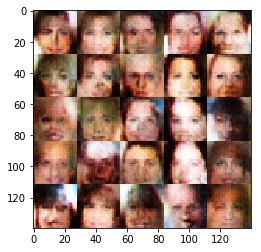

Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.8441
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.8372
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.8881
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.8255


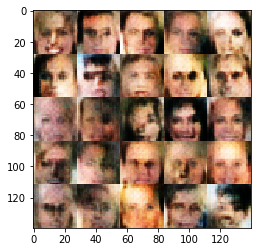

Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7590


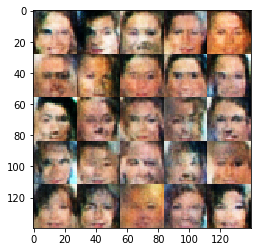

Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.8204


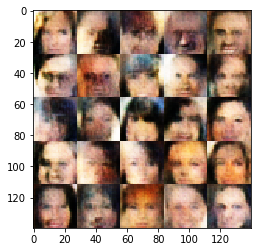

Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.7764


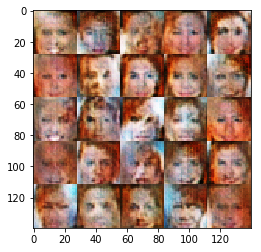

Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.7897


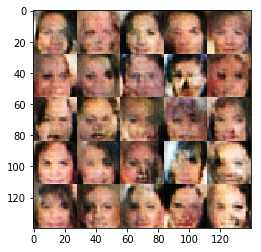

Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.7902


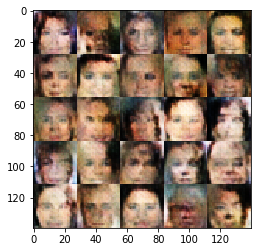

Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.7689
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.8092


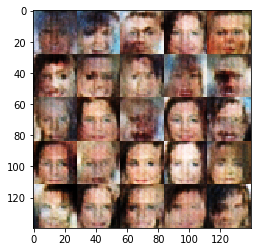

Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.8182
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.8314
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7407


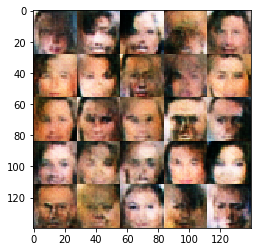

Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.7440


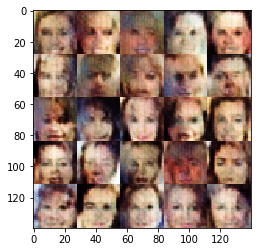

Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.7452


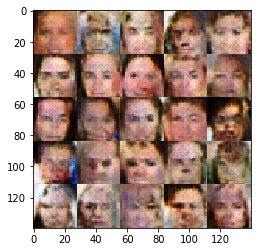

Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.7643


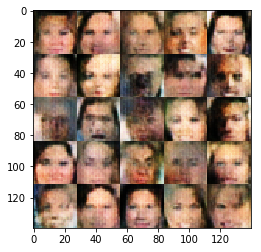

Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.8056


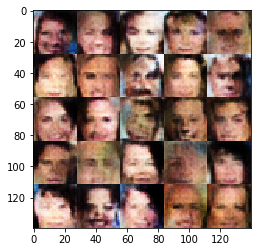

Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.7689
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.8465
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.7704


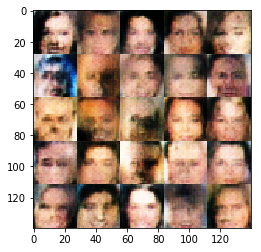

Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.8170


In [55]:
batch_size = 32
z_dim = 128
learning_rate = 0.0005
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.